In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### In this classification problem, I will use several models in order to find the classifier with the highest accuracy to assess the direction of future stock market movements (Up or Down - binary)

#### To do so, I will train each model with a data set containing data for weekly returns for 21 years

In [2]:
df = pd.read_csv('Weekly.csv')
df.head(10)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
5,1990,1.178,0.712,3.514,-2.576,-0.270,0.154444,-1.372,Down
6,1990,-1.372,1.178,0.712,3.514,-2.576,0.151722,0.807,Up
7,1990,0.807,-1.372,1.178,0.712,3.514,0.132310,0.041,Up
8,1990,0.041,0.807,-1.372,1.178,0.712,0.143972,1.253,Up
9,1990,1.253,0.041,0.807,-1.372,1.178,0.133635,-2.678,Down


In [3]:
df.dtypes

Year           int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Volume       float64
Today        float64
Direction     object
dtype: object

In [4]:
df[df.columns.drop('Direction')].corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


#### As expected, the only significant correlation is between Volume and Year

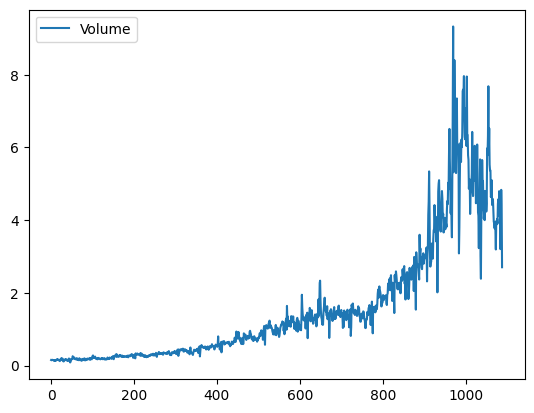

In [5]:
df.plot(y='Volume') ;

In [6]:
pred = df.columns.drop(['Year', 'Today', 'Direction'])

#### Step 1: Logistic Regression with p=6 computing Pr(Y='Up'|X=x)

In [7]:
X = MS(pred).fit_transform(df)
y = df.Direction == 'Up' # Boolean vector, then sm trasforms True into 1 and False into 0.

glm = sm.GLM(y,
             X,
             family = sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


In [8]:
y

0       False
1       False
2        True
3        True
4        True
        ...  
1084     True
1085     True
1086     True
1087     True
1088     True
Name: Direction, Length: 1089, dtype: bool

In [9]:
X

,intercept,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
0,1.0,0.816,1.572,-3.936,-0.229,-3.484,0.154976
1,1.0,-0.270,0.816,1.572,-3.936,-0.229,0.148574
2,1.0,-2.576,-0.270,0.816,1.572,-3.936,0.159837
3,1.0,3.514,-2.576,-0.270,0.816,1.572,0.161630
4,1.0,0.712,3.514,-2.576,-0.270,0.816,0.153728
...,...,...,...,...,...,...,...
1084,1.0,-0.861,0.043,-2.173,3.599,0.015,3.205160
1085,1.0,2.969,-0.861,0.043,-2.173,3.599,4.242568
1086,1.0,1.281,2.969,-0.861,0.043,-2.173,4.835082
1087,1.0,0.283,1.281,2.969,-0.861,0.043,4.454044


#### p-value is acceptable for Lag1 (-ve coeff) and Lag2 (+ve coeff), even if quite high

In [10]:
probs = results.predict()
probs

array([0.60862494, 0.60103144, 0.58756995, ..., 0.57972297, 0.55091703,
       0.52212163])

In [11]:
labels = np.array(['Down']*df.shape[0])
labels[probs > 0.5] = "Up"

In [12]:
confusion_table(labels, df.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [13]:
(54+557)/(430+48+54+557), 557/(430+557)
# Overall accuracy, accuracy when the model predicted that the stock market would go up

(0.5610651974288338, 0.5643363728470111)

#### Accuracy in predicting an Up movement is impressive at 56%. Let's try to increase the threshold to 0.6

In [14]:
labels = np.array(['Down']*df.shape[0])
labels[probs > 0.6] = "Up"
confusion_table(labels, df.Direction)

Truth,Down,Up
Predicted,,
Down,433,522
Up,51,83


In [15]:
(433+83)/(433+522+51+83), 83/(83+51)

(0.4738292011019284, 0.6194029850746269)

##### This modification gives up overall accuracy, but improves accuracy in predicting an upward movement

#### Step 2: overall accuracy is decent, but training set error rate usually underestimates the true error. For this reason, I will split training observations in order to use data from 2009 and 2010 as test data

#### Let's go back to a threshold of 0.5 and let's consider 'Lag2' as the only predictor

In [16]:
X = MS(['Lag2']).fit_transform(df)

In [17]:
filt = df.Year<2009 # df[df['Year'] < 2009] for some reason doesn't work

In [18]:
X_test, X_train = X.loc[~filt], X.loc[filt]
y_test, y_train = y.loc[~filt], y.loc[filt]

In [19]:
glm = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2033,0.064,3.162,0.002
Lag2,0.0581,0.029,2.024,0.043


In [20]:
probs = results.predict(exog=X_test)

In [21]:
probs

985     0.526129
986     0.644736
987     0.486216
988     0.485200
989     0.519767
          ...   
1084    0.551258
1085    0.538235
1086    0.592846
1087    0.568977
1088    0.554705
Length: 104, dtype: float64

In [22]:
test_label = np.array(['Down'] * X_test.shape[0])
test_label[probs>0.5] = 'Up' # Just 1 equal sign

In [24]:
y_test = df.Direction.loc[~filt]
y_test

985     Down
986     Down
987     Down
988     Down
989       Up
        ... 
1084      Up
1085      Up
1086      Up
1087      Up
1088      Up
Name: Direction, Length: 104, dtype: object

In [25]:
confusion_table(test_label, y_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [26]:
print('Overall accuracy:', 65/104,
      '\nAccuracy within Up prediction:', round(56/90, 4))

Overall accuracy: 0.625 
Accuracy within Up prediction: 0.6222


#### Step 3: LDA with p=1 (Lag2)

In [27]:
lda = LDA(store_covariance=True)

In [28]:
y_train = df.Direction.loc[filt]
y_test = df.Direction.loc[~filt]
X_train, X_test = [M.drop(columns=['intercept']) # LDA automatically adds an intercept
                   for M in [X_train, X_test]]
lda.fit(X_train, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [29]:
lda.means_, lda.classes_

(array([[-0.03568254],
        [ 0.26036581]]),
 array(['Down', 'Up'], dtype='<U4'))

#### Prior probabilities. If the market returns are negative 2 weeks before, I expect the market to go down during this week. The opposite is true.

In [30]:
lda.priors_

array([0.44771574, 0.55228426])

In [31]:
lda_pred = lda.predict(X_test)

In [32]:
lda_pred

array(['Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Down',
       'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up'],
      dtype='<U4')

In [33]:
confusion_table(lda_pred, y_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [34]:
65/104, 56/90 # I obtained exactly the same result as the logistic regression. Am I surprised? No

(0.625, 0.6222222222222222)

# QDA

In [35]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda.means_, qda.priors_ # Note: same means and prior probabilities as LDA

(array([[-0.03568254],
        [ 0.26036581]]),
 array([0.44771574, 0.55228426]))

In [36]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [37]:
61/104, 61/104 # The model always predicts the stock market to go up and it has a lower accuracy than logit and LDA

(0.5865384615384616, 0.5865384615384616)

# Naive Bayes

#### Standardize data

In [38]:
NB = GaussianNB()
NB.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [39]:
NB.classes_, NB.class_prior_

(array(['Down', 'Up'], dtype='<U4'), array([0.44771574, 0.55228426]))

In [40]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, y_test) # Same result as QDA.

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


# KNN

In [41]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, y_test)

Truth,Down,Up
Predicted,,
Down,22,30
Up,21,31


In [42]:
53/104, 31/52 # Nice performance when predicted the market would go up, but overall bad accuracy. Let's try to change K

(0.5096153846153846, 0.5961538461538461)

#### I do not need to scale here because I have just one predictor. Otherwise, I must standardize the parameters

In [45]:
for K in range(1,6): # 1,2,3,4,5
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to go Up: {1:>2},' +
             ' # who went Up {2:d}, accuracy {3:.1%}')
    pred = C.loc['Up'].sum()
    did_rent = C.loc['Up','Up']
    print(templ.format(K, pred, did_rent, did_rent / pred))

K=1: # predicted to go Up: 52, # who went Up 31, accuracy 59.6%
K=2: # predicted to go Up: 30, # who went Up 18, accuracy 60.0%
K=3: # predicted to go Up: 68, # who went Up 41, accuracy 60.3%
K=4: # predicted to go Up: 51, # who went Up 34, accuracy 66.7%
K=5: # predicted to go Up: 67, # who went Up 40, accuracy 59.7%


In [46]:
knn1 = KNeighborsClassifier(n_neighbors=4)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, y_test)

Truth,Down,Up
Predicted,,
Down,26,27
Up,17,34


In [47]:
60/104, 34/51

(0.5769230769230769, 0.6666666666666666)

#### With K=4 I have the best accuracy so far. Impressive